In [0]:
!unzip titanic.zip

In [0]:
!pip install optuna

In [0]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
import optuna

In [0]:
'''
サンプルの生成
'''
train = pd.read_csv("train.csv")      # (891, 12)
test = pd.read_csv("test.csv")        # (418, 11)
full_data = [train, test]

train_len = len(train)      # 891
test_len = len(test)        # 418

In [0]:
train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()

In [0]:
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

In [0]:
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean()

In [0]:
for dataset in full_data:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

In [0]:
for dataset in full_data:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
train[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean()

In [0]:
for dataset in full_data:
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
train['CategoricalFare'] = pd.qcut(train['Fare'], 4)
train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean()

In [0]:
for dataset in full_data:
    age_avg = dataset['Age'].mean()
    age_std = dataset['Age'].std()
    age_null_count = dataset['Age'].isnull().sum()
    
    age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
    dataset['Age'][np.isnan(dataset['Age'])] = age_null_random_list
    dataset['Age'] = dataset['Age'].astype(int)
    
train['CategoricalAge'] = pd.cut(train['Age'], 5)

train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean()


In [0]:
'''
データの前処理
'''
def missing_table(df):      # データの欠損を計算
    null_val = df.isnull().sum()
    percent = 100 * df.isnull().sum()/len(df)
    missing_table = pd.concat([null_val, percent], axis=1)
    missing_table_ren_columns = missing_table.rename(
        columns = {0:"欠損数", 1:"%"}
    )
    return missing_table_ren_columns

# missing_table(train)
# print(missing_table(test))

for i in range(len(train)):
  train["Name"][i] = train["Name"][i].split('.')[0].split(', ')[1]
for i in range(len(test)):
  test["Name"][i] = test["Name"][i].split('.')[0].split(', ')[1]

  
# 欠損の穴埋め
train["Cabin"] = train["Cabin"].fillna(0)
train["Age"] = train["Age"].fillna(train["Age"].median())
train["Embarked"] = train["Embarked"].fillna("S")
train["Sex"][train["Sex"]=="male"] = 0
train["Sex"][train["Sex"]=="female"] = 1
train["Embarked"][train["Embarked"]=="S"] = 0
train["Embarked"][train["Embarked"]=="C"] = 1
train["Embarked"][train["Embarked"]=="Q"] = 2

test["Cabin"] = test["Cabin"].fillna(0)
test["Age"] = test["Age"].fillna(test["Age"].median())
test["Sex"][test["Sex"]=="male"] = 0
test["Sex"][test["Sex"]=="female"] = 1
test["Embarked"][test["Embarked"]=="S"] = 0
test["Embarked"][test["Embarked"]=="C"] = 1
test["Embarked"][test["Embarked"]=="Q"] = 2
test["Fare"] = test["Fare"].fillna(test["Fare"].median())

train["Sex"] = pd.to_numeric(train["Sex"], errors='coerce')
train["Embarked"] = pd.to_numeric(train["Embarked"], errors='coerce')
test["Sex"] = pd.to_numeric(test["Sex"], errors='coerce')
test["Embarked"] = pd.to_numeric(test["Embarked"], errors='coerce')

In [0]:
for dataset in full_data:
    dataset.loc[ dataset['Cabin'] != 0, 'Cabin'] = 1
    
#     dataset.loc[ dataset['Name'] == 'Mr', 'Name'] = 1
#     dataset.loc[ dataset['Name'] == 'Miss', 'Name'] = 2
#     dataset.loc[ dataset['Name'] == 'Mrs', 'Name'] = 3
#     dataset.loc[ dataset['Name'] == 'Master', 'Name'] = 4
#     dataset.loc[(dataset['Name'] != 'Mr') & (dataset['Name'] != 'Miss') & (dataset['Name'] != 'Mrs') & (dataset['Name'] != 'Master'), 'Name'] = 0
    dataset['Name'] =  dataset['Name'].map({"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4})
  
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)
    
#     dataset['Familysize'] = dataset['Parch'] + dataset['SibSp']

In [0]:
train.head()

In [0]:
train['Name'] = train['Name'].fillna(0)
test['Name'] = test['Name'].fillna(0)

In [0]:
# 一人かどうか
alone_train = np.zeros((train_len))
for i in range(train_len):
    if train["Parch"][i].all()==0 and train["SibSp"][i].all()==0:
        alone_train[i] = 1
alone_test = np.zeros((test_len))
for i in range(test_len):
    if test["Parch"][i].all()==0 and test["SibSp"][i].all()==0:
        alone_test[i] = 1

list_alone_train = list(alone_train.astype(int))
pd_alone_train = pd.DataFrame({'Alone':alone_train})
train = pd.concat([train.reset_index(drop=True), pd_alone_train.reset_index(drop=True)], axis=1)
list_alone_test = list(alone_test.astype(int))
pd_alone_test = pd.DataFrame({'Alone':alone_test})
test = pd.concat([test.reset_index(drop=True), pd_alone_test.reset_index(drop=True)], axis=1)

In [0]:
corrmat = train.corr()
f, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corrmat, vmax=.8, annot = True, center = 0)

In [0]:
# n_train = 791
val_ratio = 0.3
f_name = 'model_titanic_trained.h5'
# f_name = 'model_titanic_tset.h5'

In [0]:
'''
入力の生成
'''
train_dropped = train.drop(['PassengerId', 'Ticket'], axis=1)
train_x = train_dropped.drop('Survived', axis=1)
train_y = train_dropped.Survived


In [0]:
submit_dropped = test.drop(['PassengerId', 'Ticket'], axis=1)
submit_x = submit_dropped

(train_x, val_x, train_y, val_y) = train_test_split(train_x, train_y, test_size=val_ratio, random_state=666)       # random_stateのseedを適当に固定

In [0]:
'''
ハイパーパラメータの最適化
'''
import xgboost as xgb
from sklearn.metrics import (roc_curve, auc, accuracy_score)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 0, 1000)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 20)
    learning_rate = trial.suggest_discrete_uniform('learning_rate', 0.001, 0.05, 0.001)
    scale_pos_weight = trial.suggest_int('scale_pos_weight', 1, 100)
    subsample = trial.suggest_discrete_uniform('subsample', 0.5, 0.9, 0.1)
    colsample_bytree = trial.suggest_discrete_uniform('colsample_bytree', 0.5, 0.9, 0.1)
    
    model = xgb.XGBClassifier(
        random_state=42, # ここは固定の数値
        n_estimators = n_estimators,
        max_depth = max_depth,
        min_child_weight = min_child_weight,
        learning_rate = learning_rate,
        scale_pos_weight = scale_pos_weight,
        subsample = subsample,
        colsample_bytree = colsample_bytree,
    )
    model.fit(train_x, train_y)
    return 1.0 - accuracy_score(val_y, model.predict(val_x))

In [0]:
study = optuna.create_study()
study.optimize(objective, n_trials = 100)

In [62]:
study.best_params    # 求めたハイパーパラメータ

{'colsample_bytree': 0.5,
 'learning_rate': 0.026000000000000002,
 'max_depth': 14,
 'min_child_weight': 9,
 'n_estimators': 663,
 'scale_pos_weight': 2,
 'subsample': 0.5}

In [0]:
'''
モデルの再生成
'''
model = xgb.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100)

# model = xgb.XGBClassifier(
#     colsample_bytree = 0.5,
#     max_depth=14,
#     learning_rate=0.026,
#     n_estimators=663,
#     min_child_weight = 9,
#     scale_pos_weight = 2,
#     subsample = 0.5
# )

In [0]:
'''
学習
'''
model = model.fit(
    train_x, train_y
)

In [68]:
'''
評価
'''
from sklearn.metrics import (roc_curve, auc, accuracy_score)

predict = model.predict(val_x)
print(accuracy_score(val_y, predict))

0.8208955223880597


In [69]:
'''
提出
'''
# submit_model = model.fit(train_x, train_y)
submit_xgb = model.predict(submit_x)
submit_xgb = np.round(submit_xgb).astype(int)
submit_xgb = submit_xgb.flatten()
submit_xgb

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [0]:
def deference(x, y):
  h = 0
  for i in range(len(x)):
    if x[i] != y[i]:
      h += 1
  return h

In [88]:
deference(submit_xgb, submit_dnn)

48

In [0]:
def vote(x, y, z):
  score = 0
  if x + y + z >= 2:
    score = 1
  return score

voted = []

for i in range(len(submit_svm)):
  voted.append(vote(submit_xgb[i], submit_rf[i], submit_dnn[i]))
  

In [0]:
voted = np.array(voted)

In [117]:
deference(voted, submit_rf)

21

In [111]:
def mixing(x):
  j = 0
  h = 0
  mix = []
  for i in range(len(x)):
      if x[i] != submit_dnn[i]:
          frag = 0
          for t in range(len(hard_predict_dnn)):
              if hard_predict_dnn[t]== i:
                  mix.append(submit_dnn[i])
                  frag += 1
                  h += 1
          if frag==0:
              mix.append(x[i])
          j += 1
      else:
          mix.append(x[i])
  print(j,h,len(mix))
  return mix
  
mix = mixing(submit_xgb)

48 0 418


In [0]:
submit_mix = np.array(mix)

In [0]:
# PassengerIdを取得
PassengerId = np.array(test["PassengerId"]).astype(int)
 
# my_prediction(予測データ）とPassengerIdをデータフレームへ落とし込む
# my_solution = pd.DataFrame(submit_xgb, PassengerId, columns = ["Survived"])
# my_solution = pd.DataFrame(submit_mix, PassengerId, columns = ["Survived"])
my_solution = pd.DataFrame(voted, PassengerId, columns = ["Survived"])
# my_solution = pd.DataFrame(submit_svm, PassengerId, columns = ["Survived"])
 
# my_tree_one.csvとして書き出し
my_solution.to_csv("nn.csv", index_label = ["PassengerId"])

In [0]:
submit_xgb = ([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [0]:
submit_svm = ([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1])

In [0]:
submit_dnn = ([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1])

In [0]:
submit_gcForest = ([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [0]:
submit_rf = ([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1])

In [0]:
hard_predict_dnn = ([  3,   5,   9,  10,  12,  14,  15,  22,  24,  25,  26,  29,  31,
        38,  39,  40,  42,  43,  44,  45,  48,  56,  58,  59,  60,  62,
        64,  65,  71,  74,  76,  77,  83,  85,  91,  92,  93,  95,  96,
        97,  99, 100, 103, 105, 108, 112, 114, 115, 122, 123, 126, 129,
       130, 132, 133, 134, 135, 139, 145, 147, 149, 150, 152, 155, 156,
       163, 167, 168, 170, 172, 174, 178, 179, 182, 184, 187, 195, 196,
       208, 209, 210, 211, 218, 219, 221, 222, 223, 224, 226, 228, 232,
       235, 239, 240, 243, 246, 251, 253, 254, 255, 257, 259, 260, 261,
       265, 267, 269, 272, 285, 286, 289, 294, 295, 296, 297, 299, 300,
       303, 305, 310, 312, 314, 318, 319, 320, 325, 326, 334, 337, 341,
       342, 343, 350, 356, 357, 361, 362, 363, 364, 366, 368, 371, 374,
       375, 386, 391, 394, 395, 397, 398, 400, 411, 413, 414, 415, 416])

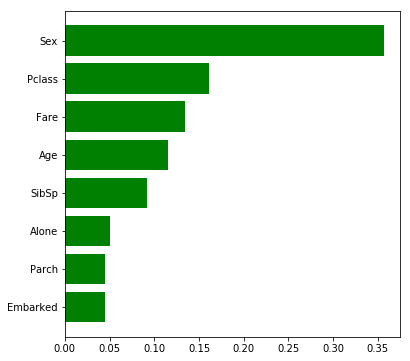

In [0]:
'''
変数重要度の可視化
'''
import matplotlib.pyplot as plt

features = train_x.columns
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(6,6))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.show()